# Handwritten Digit Classfication using Lenet

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import time
import pandas

In [3]:
from nn.layer import *
from optim.optimizer import *
from util.common import *
from dataset.transformer import *
from dataset import mnist

In [4]:
# Init Engine with 1 nodes and each node with 4 cores
initEngine(1, 4)

## 1. Train the network

* prepare train and validation samples

In [5]:
# Get and store MNIST into RDD of Sample
def get_minst(data_type="train"):
    # target is start from 0,
    (images, labels) = mnist.read_data_sets("/tmp/mnist/", data_type)
    images = sc.parallelize(images)
    labels = sc.parallelize(labels)
    record = images.zip(labels).map(lambda (features, label):
        Sample.from_ndarray(features, label + 1)) # Both features and labels are ndarray, and BigDL target starts from 1
    return record

train_rdd = get_minst("train")
val_rdd = get_minst("test")
print train_rdd.count()
print val_rdd.count()

('Extracting', '/tmp/mnist/train-images-idx3-ubyte.gz')
('Extracting', '/tmp/mnist/train-labels-idx1-ubyte.gz')
('Extracting', '/tmp/mnist/t10k-images-idx3-ubyte.gz')
('Extracting', '/tmp/mnist/t10k-labels-idx1-ubyte.gz')
60000
10000


* normalize the samples

In [6]:
# Transform Image samples through map function
train_data = train_rdd.map(normalizer(mnist.TRAIN_MEAN, mnist.TRAIN_STD))
test_data = val_rdd.map(normalizer(mnist.TEST_MEAN, mnist.TEST_STD))

In [7]:
# Create a LeNet model
def build_model(class_num):
    model = Sequential()
    model.add(Reshape([1, 28, 28]))
    model.add(SpatialConvolution(1, 6, 5, 5))
    model.add(Tanh())
    model.add(SpatialMaxPooling(2, 2, 2, 2))
    model.add(Tanh())
    model.add(SpatialConvolution(6, 12, 5, 5))
    model.add(SpatialMaxPooling(2, 2, 2, 2))
    model.add(Reshape([12 * 4 * 4]))
    model.add(Linear(12 * 4 * 4, 100))
    model.add(Tanh())
    model.add(Linear(100, class_num))
    model.add(LogSoftMax())
    return model
lenet_model = build_model(10)
lenet_model

creating: createSequential
creating: createReshape
creating: createSpatialConvolution
creating: createTanh
creating: createSpatialMaxPooling
creating: createTanh
creating: createSpatialConvolution
creating: createSpatialMaxPooling
creating: createReshape
creating: createLinear
creating: createTanh
creating: createLinear
creating: createLogSoftMax


* configure optimizer

In [8]:
# Create an Optimizer
state = {"learningRate": 0.01,
         "learningRateDecay": 0.0002}
optimizer = Optimizer(
    model=lenet_model,
    training_rdd=train_data,
    criterion=ClassNLLCriterion(),
    optim_method="SGD",
    state=state,
    end_trigger=MaxEpoch(2),
    batch_size=128)

# Set the validation logic
optimizer.setvalidation(
    batch_size=32,
    val_rdd=test_data,
    trigger=EveryEpoch(),
    val_method=["top1"]
)

# Set the model checkpoint logic
#optimizer.setcheckpoint(EveryEpoch(), "/tmp/lenet5/")

#You would see the model snapshot at dir:/tmp/lenet5/ for every epoch

creating: createClassNLLCriterion
creating: createMaxEpoch
creating: createOptimizer
creating: createEveryEpoch


* Train the network. Wait some time till it finished.. Voila! You've got a trained model

In [9]:
%%time
# Boot training process
trained_model = optimizer.optimize()
print "Optimization Done."

Optimization Done.
CPU times: user 4 ms, sys: 8 ms, total: 12 ms
Wall time: 1min 46s


## 2 Inspect the prediction results

* Let's take a look at the prediction results

In [10]:
def map_predict_label(l):
    return np.array(l).argmax()
def map_groundtruth_label(l):
    return l[0] - 1

5.0, 0.0, 4.0, 1.0, 9.0, 2.0, 1.0, 3.0


(-0.5, 223.5, 27.5, -0.5)

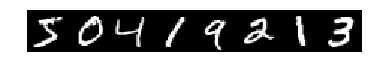

In [11]:
# label-1 to restore the original label.
train_mini = train_data.take(8)
print ', '.join([str(map_groundtruth_label(s.label)) for s in train_mini ])
imshow(np.column_stack([np.array(s.features).reshape(28,28) for s in train_mini]),cmap='gray'); axis('off')

Ground Truth labels:
7.0, 2.0, 1.0, 0.0, 4.0, 1.0, 4.0, 9.0
Predicted labels:
7, 2, 1, 0, 4, 1, 4, 4
CPU times: user 84 ms, sys: 0 ns, total: 84 ms
Wall time: 429 ms


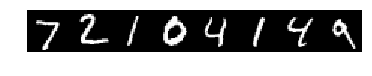

In [12]:
%%time
predictions = trained_model.predict(test_data)
imshow(np.column_stack([np.array(s.features).reshape(28,28) for s in test_data.take(8)]),cmap='gray'); axis('off')
print 'Ground Truth labels:'
print ', '.join(str(map_groundtruth_label(s.label)) for s in test_data.take(8))
#print 'Ground Truth:'
#print '\t'.join([str(s.label) for s in ground_truth])
print 'Predicted labels:'
print ', '.join(str(map_predict_label(s.label)) for s in predictions.take(8))